In [1]:
import numpy as np
import pandas as pd
import librosa

import os
import time
import re
from tqdm import tqdm
import h5py

import tensorflow as tf
from tensorflow.keras.utils import to_categorical, plot_model

import matplotlib.pyplot as plt
import IPython.display
import librosa.display

import ESC 
from tensorflow.keras.regularizers import l2

# Use GPU
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5215292279888429166
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 775768225440946679
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7046801664
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8966133601371677990
physical_device_desc: "device: 0, name: GeForce GTX 1070, pci bus id: 0000:01:00.0, compute capability: 6.1"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 719393340636387490
physical_device_desc: "device: XLA_GPU device"
]


## Load Data
Scaling directly the audio data to range 0-1 makes no sense because it will affect the melspectrogram conversion, so we have to:
1. Load data.
2. Compute spectrogram segments.
3. Merge all folds segments and find min-max in order to scale consistently across different folds.
4. Split the datasets again.

In [2]:
PATH = 'audio'
raw_files, cvs, labels = ESC.Load_RAW(PATH)

# Split the different folds
f1, f2, f3, f4, f5 = ESC.Split_Folds(raw_files, cvs, labels, verbose=True)

100%|██████████| 2000/2000 [00:00<00:00, 500036.24it/s]

Folds size: 400 - 400 - 400 - 400 - 400
Folds sample shape:  2
Folds sample data shape:  (110250,)
Folds sample label type:  (50,)


In [3]:
af4, alf4 = ESC.Split_Data_Label(f4)

In [4]:
# Load augmented
af1, alf1 = ESC.Load_Augmented(name='af1', path='Augmented_2/')
af2, alf2 = ESC.Load_Augmented(name='af2', path='Augmented_2/')
af3, alf3 = ESC.Load_Augmented(name='af3', path='Augmented_2/')
#af4, alf4 = ESC.Load_Augmented(name='af4', path='Augmented_2/')
#af5, alf5 = ESC.Load_Augmented(name='af5', path='Augmented_2/')

In [5]:
# Compute log-melspec and deltas
f1p, lf1p = ESC.Preprocessing(af1, alf1)
f2p, lf2p = ESC.Preprocessing(af2, alf2)
f3p, lf3p = ESC.Preprocessing(af3, alf3)
f4p, lf4p = ESC.Preprocessing(af4, alf4)
#f5p, lf5p = ESC.Preprocessing(af5, alf5)

100%|██████████| 400/400 [00:02<00:00, 148.92it/s]


In [6]:
# Scale the data in each fold to 0 1
f1p = np.interp(f1p, (f1p.min(), f1p.max()), (0, +1))
f2p = np.interp(f2p, (f2p.min(), f2p.max()), (0, +1))
f3p = np.interp(f3p, (f3p.min(), f3p.max()), (0, +1))
f4p = np.interp(f4p, (f4p.min(), f4p.max()), (0, +1))
#f5p = np.interp(f5p, (f5p.min(), f5p.max()), (0, +1))


# Define Network and Training

In [7]:
ESResNet = ESC.ESResNet([60, 41, 2])

print(ESResNet.summary())
opt = tf.keras.optimizers.Adam(lr=0.00001)
loss_f = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
ESResNet.compile(optimizer=opt, loss=loss_f, metrics=["accuracy"])

Model: "ESResNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 60, 41, 2)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 30, 21, 64)   6336        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 30, 21, 64)   256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 30, 21, 64)   0           batch_normalization[0][0]        
___________________________________________________________________________________________

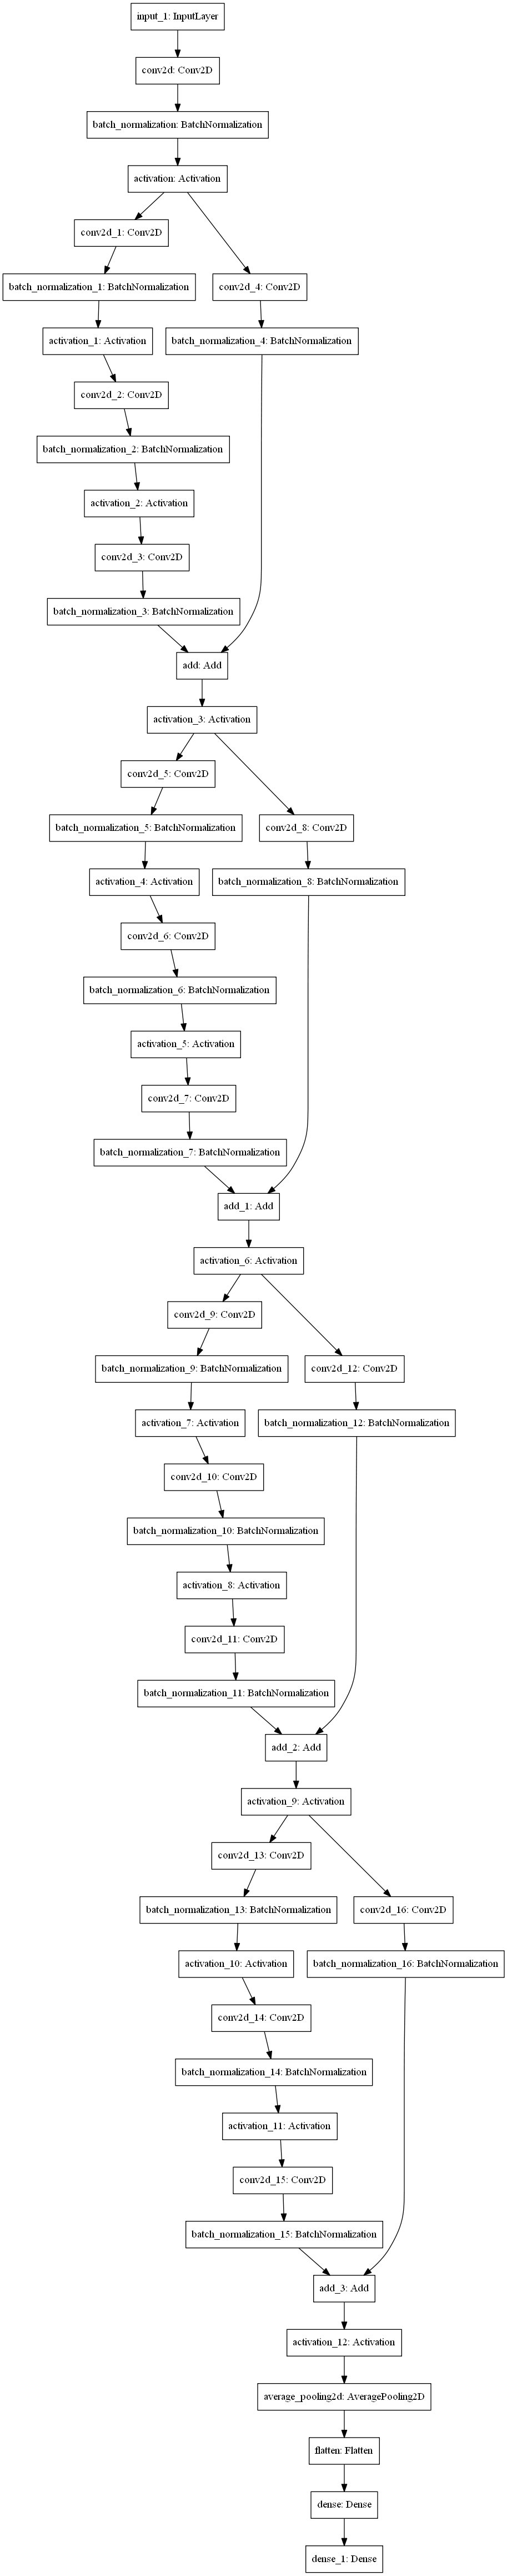

In [8]:
plot_model(ESResNet)

In [11]:
training_dataset = ESC.CreateTrainingSet(f1p, f2p, f3p, lf1p, lf2p, lf3p, batch_size=16)
validation_dataset = ESC.CreateValidationSet(f4p, lf4p, batch_size=16)

In [12]:
max_epochs = 30

epoch_loss= []
epoch_acc = []

epoch_vl = []
epoch_va = []

# Loop over the epochs
for epoch in range(max_epochs):

    
    step_loss = []
    step_acc = []
    
    step_vl = []
    step_va = []
    
    start = time.time()
    # train over mini-batches
    for x_batch, y_batch in training_dataset:
        
        # train on batch
        step_stats = ESResNet.train_on_batch(x_batch, y_batch)
        
        # save loss and accuracy
        step_loss.append(step_stats[0])
        step_acc.append(step_stats[1])
        
    # compute validation stats
    for x_batch, y_batch in validation_dataset:
        
        # compute validation stats
        val_stats = ESResNet.test_on_batch(x_batch, y_batch)
        
        # save loss and accuracy
        step_vl.append(val_stats[0])
        step_va.append(val_stats[1])
    end = time.time()
        
    # Save the mean loss and accuracy of the entire epoch
    epoch_loss.append(np.mean(step_loss))
    epoch_acc.append(np.mean(step_acc))
    epoch_vl.append(np.mean(step_vl))
    epoch_va.append(np.mean(step_va))
    
    # Print epoch training stats
    print("Epoch %2d: \t t-loss: %3.6f \t t-acc: %.6f \t v-loss: %3.6f \t v-acc: %.6f \t time: %3.3f" % (epoch + 1, epoch_loss[-1], epoch_acc[-1], epoch_vl[-1], epoch_va[-1], (end - start)))
    

Epoch  1: 	 t-loss: 2.274742 	 t-acc: 0.380630 	 v-loss: 2.540386 	 v-acc: 0.350833 	 time: 957.591
Epoch  2: 	 t-loss: 1.324986 	 t-acc: 0.621037 	 v-loss: 3.266730 	 v-acc: 0.346944 	 time: 948.099
Epoch  3: 	 t-loss: 0.972089 	 t-acc: 0.720333 	 v-loss: 3.492653 	 v-acc: 0.345556 	 time: 948.307
Epoch  4: 	 t-loss: 0.773511 	 t-acc: 0.776722 	 v-loss: 3.384333 	 v-acc: 0.356667 	 time: 954.372
Epoch  5: 	 t-loss: 0.650592 	 t-acc: 0.812204 	 v-loss: 3.572652 	 v-acc: 0.356667 	 time: 948.332


KeyboardInterrupt: 

print(f1p[0, :, :, 0].shape)
plt.figure()
for elem in f1p[5, :, :, 0]:
    plt.plot(elem)
plt.show()

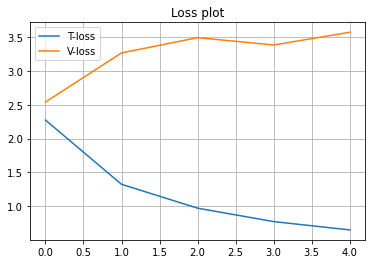

In [13]:
plt.figure()
plt.plot(epoch_loss, label='T-loss')
plt.plot(epoch_vl, label='V-loss')
plt.title('Loss plot')
plt.grid()
plt.legend()
plt.show()

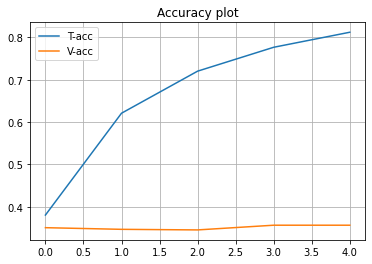

In [14]:
plt.figure()
plt.plot(epoch_acc, label='T-acc')
plt.plot(epoch_va, label='V-acc')
plt.title('Accuracy plot')
plt.grid()
plt.legend()
plt.show()